In [5]:
import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

#  U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.models import Model

# Get Data

In [17]:
width_shape, height_shape = 512, 512 # Tamaño de las imagenes de entrada
batch_size = 16
epochs = 20
train_x_path = "/content/drive/MyDrive/Colab Notebooks/hackathon/data/Train/Image/"   
train_mask_path = "/content/drive/MyDrive/Colab Notebooks/hackathon/data/Train/Mask/" 

In [24]:
X_train = []
y_train = []
for file in tqdm(os.listdir(train_x_path)):
  X_train.append(imread(train_x_path + file))
  y_train.append(imread(train_mask_path + file ))

xx =[i.reshape((512, 512,1)) for i in X_train]
yy = [i.reshape((512, 512,1)) for i in y_train]

if height_shape != 512:
  xx = [resize(i, (height_shape, width_shape),mode='constant', preserve_range=True ) for i in xx]
  yy = [resize(i, (height_shape, width_shape),mode='constant', preserve_range=True ) for i in yy]
xx = np.asarray(xx,dtype=np.uint8)
yy = np.asarray(yy,dtype=np.bool)

100%|██████████| 1250/1250 [00:13<00:00, 91.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [28]:
yy.shape

(1250, 512, 512, 1)

# Define the architecture
From https://www.kaggle.com/vbookshelf/simple-cell-segmentation-with-keras-and-u-net

In [37]:
inputs = Input((height_shape, width_shape, 1))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['BinaryIoU'] )

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 512, 512, 1)  0           ['input_8[0][0]']                
                                                                                                  
 conv2d_79 (Conv2D)             (None, 512, 512, 16  160         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

# Train

In [38]:
filepath = "/content/drive/MyDrive/Colab Notebooks/hackathon/model.h5"
# From https://www.kaggle.com/vbookshelf/simple-cell-segmentation-with-keras-and-u-net
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(xx, yy, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=callbacks_list)

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 0.1254 - binary_io_u: 0.4969
Epoch 1: val_loss improved from inf to 0.07967, saving model to /content/drive/MyDrive/Colab Notebooks/hackathon/model.h5
71/71 [==============================] - 121s 2s/step - loss: 0.1254 - binary_io_u: 0.4969 - val_loss: 0.0797 - val_binary_io_u: 0.4934
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 0.0984 - binary_io_u: 0.5647
Epoch 2: val_loss did not improve from 0.07967
71/71 [==============================] - 113s 2s/step - loss: 0.0984 - binary_io_u: 0.5647 - val_loss: 0.0801 - val_binary_io_u: 0.5063
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 0.0925 - binary_io_u: 0.6049
Epoch 3: val_loss improved from 0.07967 to 0.07927, saving model to /content/drive/MyDrive/Colab Notebooks/hackathon/model.h5
71/71 [==============================] - 114s 2s/step - loss: 0.0925 - binary_io_u: 0.6049 - val_loss: 0.0793 - val_binary_io_u: 0.5106
Epoch 

# Test

In [39]:
X_test = {}
X_test['ImageId'] = []
X_test['EncodedPixels'] = []
X_test['Images'] = []
test_path = '/content/drive/MyDrive/Colab Notebooks/hackathon/data/Test/Image/'
for file in tqdm(os.listdir(test_path)):
  X_test['Images'].append(imread(test_path + file))
  X_test['ImageId'].append(file.replace('.png',''))

100%|██████████| 400/400 [00:06<00:00, 64.10it/s] 


In [42]:

# import packages
import cv2
import json
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


def rle_encoding_2(x):
    '''
    x: numpy array of shape (height, width), non 0 - mask, 0 - background
    Returns run length as list
    '''
    run_lengths = []
    for i in range(1):
        run_lengths.append([])
        dots = np.where(x.T.flatten()==i+1)[0] # .T sets Fortran order down-then-right
        prev = -2
        for b in dots:
            if (b>prev+1): run_lengths[-1].extend((b, 0))
            run_lengths[-1][-1] += 1
            prev = b
    return run_lengths 

In [78]:
X_test['preproces'] = []
X_test['prediction'] = []
X_test['EncodedPixels'] = []
for image in tqdm(X_test['Images']):
  temp = image.copy()
  temp =temp.reshape((512, 512,1))
  #temp = resize(temp, (height_shape, width_shape),mode='constant', preserve_range=True )
 # temp = np.asarray(temp,dtype=np.uint8)
  X_test['preproces'].append(temp)
batch_temp = np.asarray(X_test['preproces'],dtype=np.uint8)
pred = model.predict(batch_temp)
for i in tqdm(range(pred.shape[0])):
  p_temp = pred[i,:,:,0]
  #p_temp = resize(p_temp, (512, 512),mode='constant', preserve_range=True )
  encoding_2 = rle_encoding_2((p_temp >= 0.5).astype('uint8'))
  #if len(encoding_2[0]) == 0:
  #  encoding_2[0] = ''
  encoding_2 = str(encoding_2).replace('[', '').replace(']', '').replace(',', '')
  X_test['EncodedPixels'].append(encoding_2)

100%|██████████| 400/400 [00:00<00:00, 612.83it/s]


In [79]:
import pandas as pd
df = pd.DataFrame({'ImageId' : X_test['ImageId'], 'EncodedPixels': X_test['EncodedPixels']})

In [80]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/hackathon/threshold_0_12.csv", index = False)

In [81]:
df[df['EncodedPixels'] != '']

,ImageId,EncodedPixels
38,9066,173286 1
43,9083,80225 1 80736 3 81246 5 81758 6 82268 1 82270 ...
49,9052,72441 1 73460 4 73970 6 74480 8 74988 12 75500...
51,9072,144544 2 145055 5 145567 6 146080 6 146594 2 1...
55,9080,166826 1 167338 1 167851 3 168363 2 168876 2 1...
...,...,...
291,9349,113105 1
298,9343,189166 1 190190 1 190702 1 191214 1
304,9345,201666 1 202690 3 203203 1 203715 2 204227 1
309,9311,45702 2 46215 1 46728 1 47241 1


In [107]:
df[df['ImageId'] =='9083']

,ImageId,EncodedPixels
43,9083,80225 1 80736 3 81246 5 81758 6 82268 1 82270 ...


In [109]:
i =43

In [110]:
(p_temp >= 0.2).astype('uint8')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


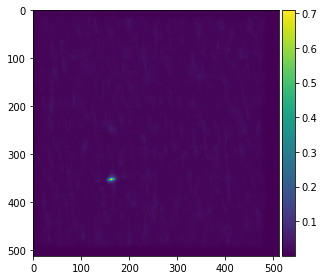

In [111]:
imshow((pred[i,:,:, 0]))

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


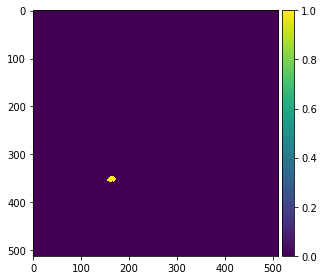

In [112]:
imshow((pred[i,:,:, 0] >= 0.11).astype('uint8'))

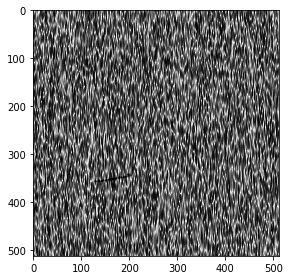

In [113]:
imshow(X_test['Images'][i])

In [83]:
(p_temp >= 0.2).astype('uint8').shape

(512, 512)